In [2]:
import numpy
import pandas
import matplotlib
import matplotlib.pyplot
import mpl_toolkits.axes_grid1
%matplotlib inline

from n2lite import n2lite

In [3]:
beam_list = ['2l', '2r', '3l', '3r',
             '4l', '4r', '5l', '5r', 
             '1lu', '1ll', '1ru', '1rl']

In [4]:
# read hot data

beam1 = '4l'
beam2 = '4r'
beam3 = '5r' # ??
beam = [beam1, beam2, beam3]
backend = ['pm1', 'pm2', 'xffts']
backend_table = ['power_1', 'power_2', 'xffts_1']

fn_hot = '20181115_053611'
fn_cold = '20181115_050528'

path_cold = '/home/amigos/data/sql/hemt_sweep/' + fn_cold + '/param.db'
path_hot = '/home/amigos/data/sql/hemt_sweep/' + fn_hot + '/param.db'

In [5]:
_hot = n2lite.N2lite(path_hot)
_cold = n2lite.N2lite(path_cold)
hot = _hot.read_pandas_all()
cold = _cold.read_pandas_all()

In [6]:
# set tuning param

initial_vg1 = -2
final_vg1 = 2
initial_vg2 = -2
final_vg2 = 2
step = 0.1
roop = int((final_vg2- initial_vg2) / step) + 1

In [7]:
# offset correct

offset_hot_vg1 = [- (final_vg1 + numpy.mean(hot['hemt_vg1_{}'.format(_beam)][0:100]))
                                  for _beam in beam]
offset_hot_vg2 = [- (final_vg2 + numpy.mean(hot['hemt_vg2_{}'.format(_beam)][0:100]))
                                  for _beam in beam]
offset_cold_vg1 = [- (final_vg1 + numpy.mean(cold['hemt_vg1_{}'.format(_beam)][0:100]))
                                  for _beam in beam]
offset_cold_vg2 = [- (final_vg2 + numpy.mean(cold['hemt_vg2_{}'.format(_beam)][0:100]))
                                  for _beam in beam]
for _beam, _offset_hot_vg1, _offset_hot_vg2, _offset_cold_vg1, _offset_cold_vg2 in zip(beam, offset_hot_vg1, offset_hot_vg2,
                                                                                       offset_cold_vg1, offset_cold_vg2):
    hot['hemt_vg1_{}'.format(_beam)] = hot['hemt_vg1_{}'.format(_beam)] + _offset_hot_vg1
    hot['hemt_vg2_{}'.format(_beam)] = hot['hemt_vg2_{}'.format(_beam)] + _offset_hot_vg2
    cold['hemt_vg1_{}'.format(_beam)] = cold['hemt_vg1_{}'.format(_beam)] + _offset_cold_vg1
    cold['hemt_vg2_{}'.format(_beam)] = cold['hemt_vg2_{}'.format(_beam)] + _offset_cold_vg2

In [8]:
bins_vg1 = numpy.arange(initial_vg1, final_vg2 + step, step)
bins_vg2 = numpy.arange(initial_vg2, final_vg2 + step, step)

def set_flag_vg1(x):
    mask = 0.05
    for i in range(len(bins_vg1)):
        if x >= bins_vg1[i] - mask and x < bins_vg1[i] + mask: return i
        continue
def set_flag_vg2(x):
    mask = 0.05
    for i in range(len(bins_vg2)):
        if x >= bins_vg2[i] - mask and x < bins_vg2[i] + mask: return i
        continue        

In [9]:
# x : vg1 flag, y : vg2 flag

for _beam, _backend in zip(beam, backend):
    hot['{}_vg1_flag'.format(_backend)] = hot['hemt_vg1_{}'.format(_beam)].apply(set_flag_vg1)
    hot['{}_vg2_flag'.format(_backend)] = hot['hemt_vg2_{}'.format(_beam)].apply(set_flag_vg2)
    cold['{}_vg1_flag'.format(_backend)] = cold['hemt_vg1_{}'.format(_beam)].apply(set_flag_vg1)
    cold['{}_vg2_flag'.format(_backend)] = cold['hemt_vg2_{}'.format(_beam)].apply(set_flag_vg2)

In [10]:
idx_hot = [
    [
        [
        hot['{}_vg2_flag'.format(_backend)][hot['{}_vg2_flag'.format(_backend)] == _vg2][hot['{}_vg1_flag'.format(_backend)] == _vg1].index
        for _vg2 in range(roop)
        ]
    for _vg1 in range(roop)
    ]
for _backend in backend
]

idx_cold = [
    [
        [
        cold['{}_vg2_flag'.format(_backend)][cold['{}_vg2_flag'.format(_backend)] == _vg2][cold['{}_vg1_flag'.format(_backend)] == _vg1].index
        for _vg2 in range(roop)
        ]
    for _vg1 in range(roop)
    ]
for _backend in backend
]

In [11]:
# calc param.

hot_groupby =  [
    [
        [
        hot['{}'.format(_backend_table)][idx_vg2]
        for idx_vg2 in idx_vg1
        ]
    for idx_vg1 in idx_hot[idx]
    ]
for _backend_table, idx in zip(backend_table, range(len(backend)))
]

hot_mean =  [
    [
        [
        hot_groupby[_idx][idx_vg1][idx_vg2].mean()
        for idx_vg2 in range(roop)
        ]
    for idx_vg1 in range(roop)
    ]
for _idx in range(len(backend))
]

cold_groupby =  [
    [
        [
        cold['{}'.format(_backend_table)][idx_vg2]
        for idx_vg2 in idx_vg1
        ]
    for idx_vg1 in idx_cold[idx]
    ]
for _backend_table, idx in zip(backend_table, range(len(backend)))
]

cold_mean =  [
    [
        [
        cold_groupby[_idx][idx_vg1][idx_vg2].mean()
        for idx_vg2 in range(roop)
        ]
    for idx_vg1 in range(roop)
    ]
for _idx in range(len(backend))
]

# dB
y =  [
    [
        [
        hot_mean[_idx][idx_vg1][idx_vg2] - cold_mean[_idx][idx_vg1][idx_vg2]
        for idx_vg2 in range(roop)
        ]
    for idx_vg1 in range(roop)
    ]
for _idx in range(len(backend))
]

# linear
Y =  [[[0 for idx_vg2 in range(roop)] for idx_vg1 in range(roop)]
        for _idx in range(len(backend))]
for _idx in range(len(backend)):
    for idx_vg1 in range(roop):
        for idx_vg2 in range(roop):
            if y[_idx][idx_vg1][idx_vg2] <= 0: Y[_idx][idx_vg1][idx_vg2] = 0
            elif  4 <= y[_idx][idx_vg1][idx_vg2]: Y[_idx][idx_vg1][idx_vg2] = 0
            else: Y[_idx][idx_vg1][idx_vg2] = 10 ** (y[_idx][idx_vg1][idx_vg2] / 10)

Tcold = 77
Thot = 300
Trx = [
    [
        [
            (Tcold * Y[_idx][idx_vg1][idx_vg2] - Thot) / (1 - Y[_idx][idx_vg1][idx_vg2])
            for idx_vg2 in range(roop)
        ]
        for idx_vg1 in range(roop)
    ]
    for _idx in range(len(backend))
]

In [30]:
vg1_map = numpy.arange(-2., 2.5, 0.5)
vg2_map = numpy.arange(-2., 2.5, 0.5)
vg2_map
# vg1_map = numpy.arange(initial_vg1, final_vg1 + step, step)
# vg2_map = numpy.arange(initial_vg2, final_vg2 + step, step)

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])

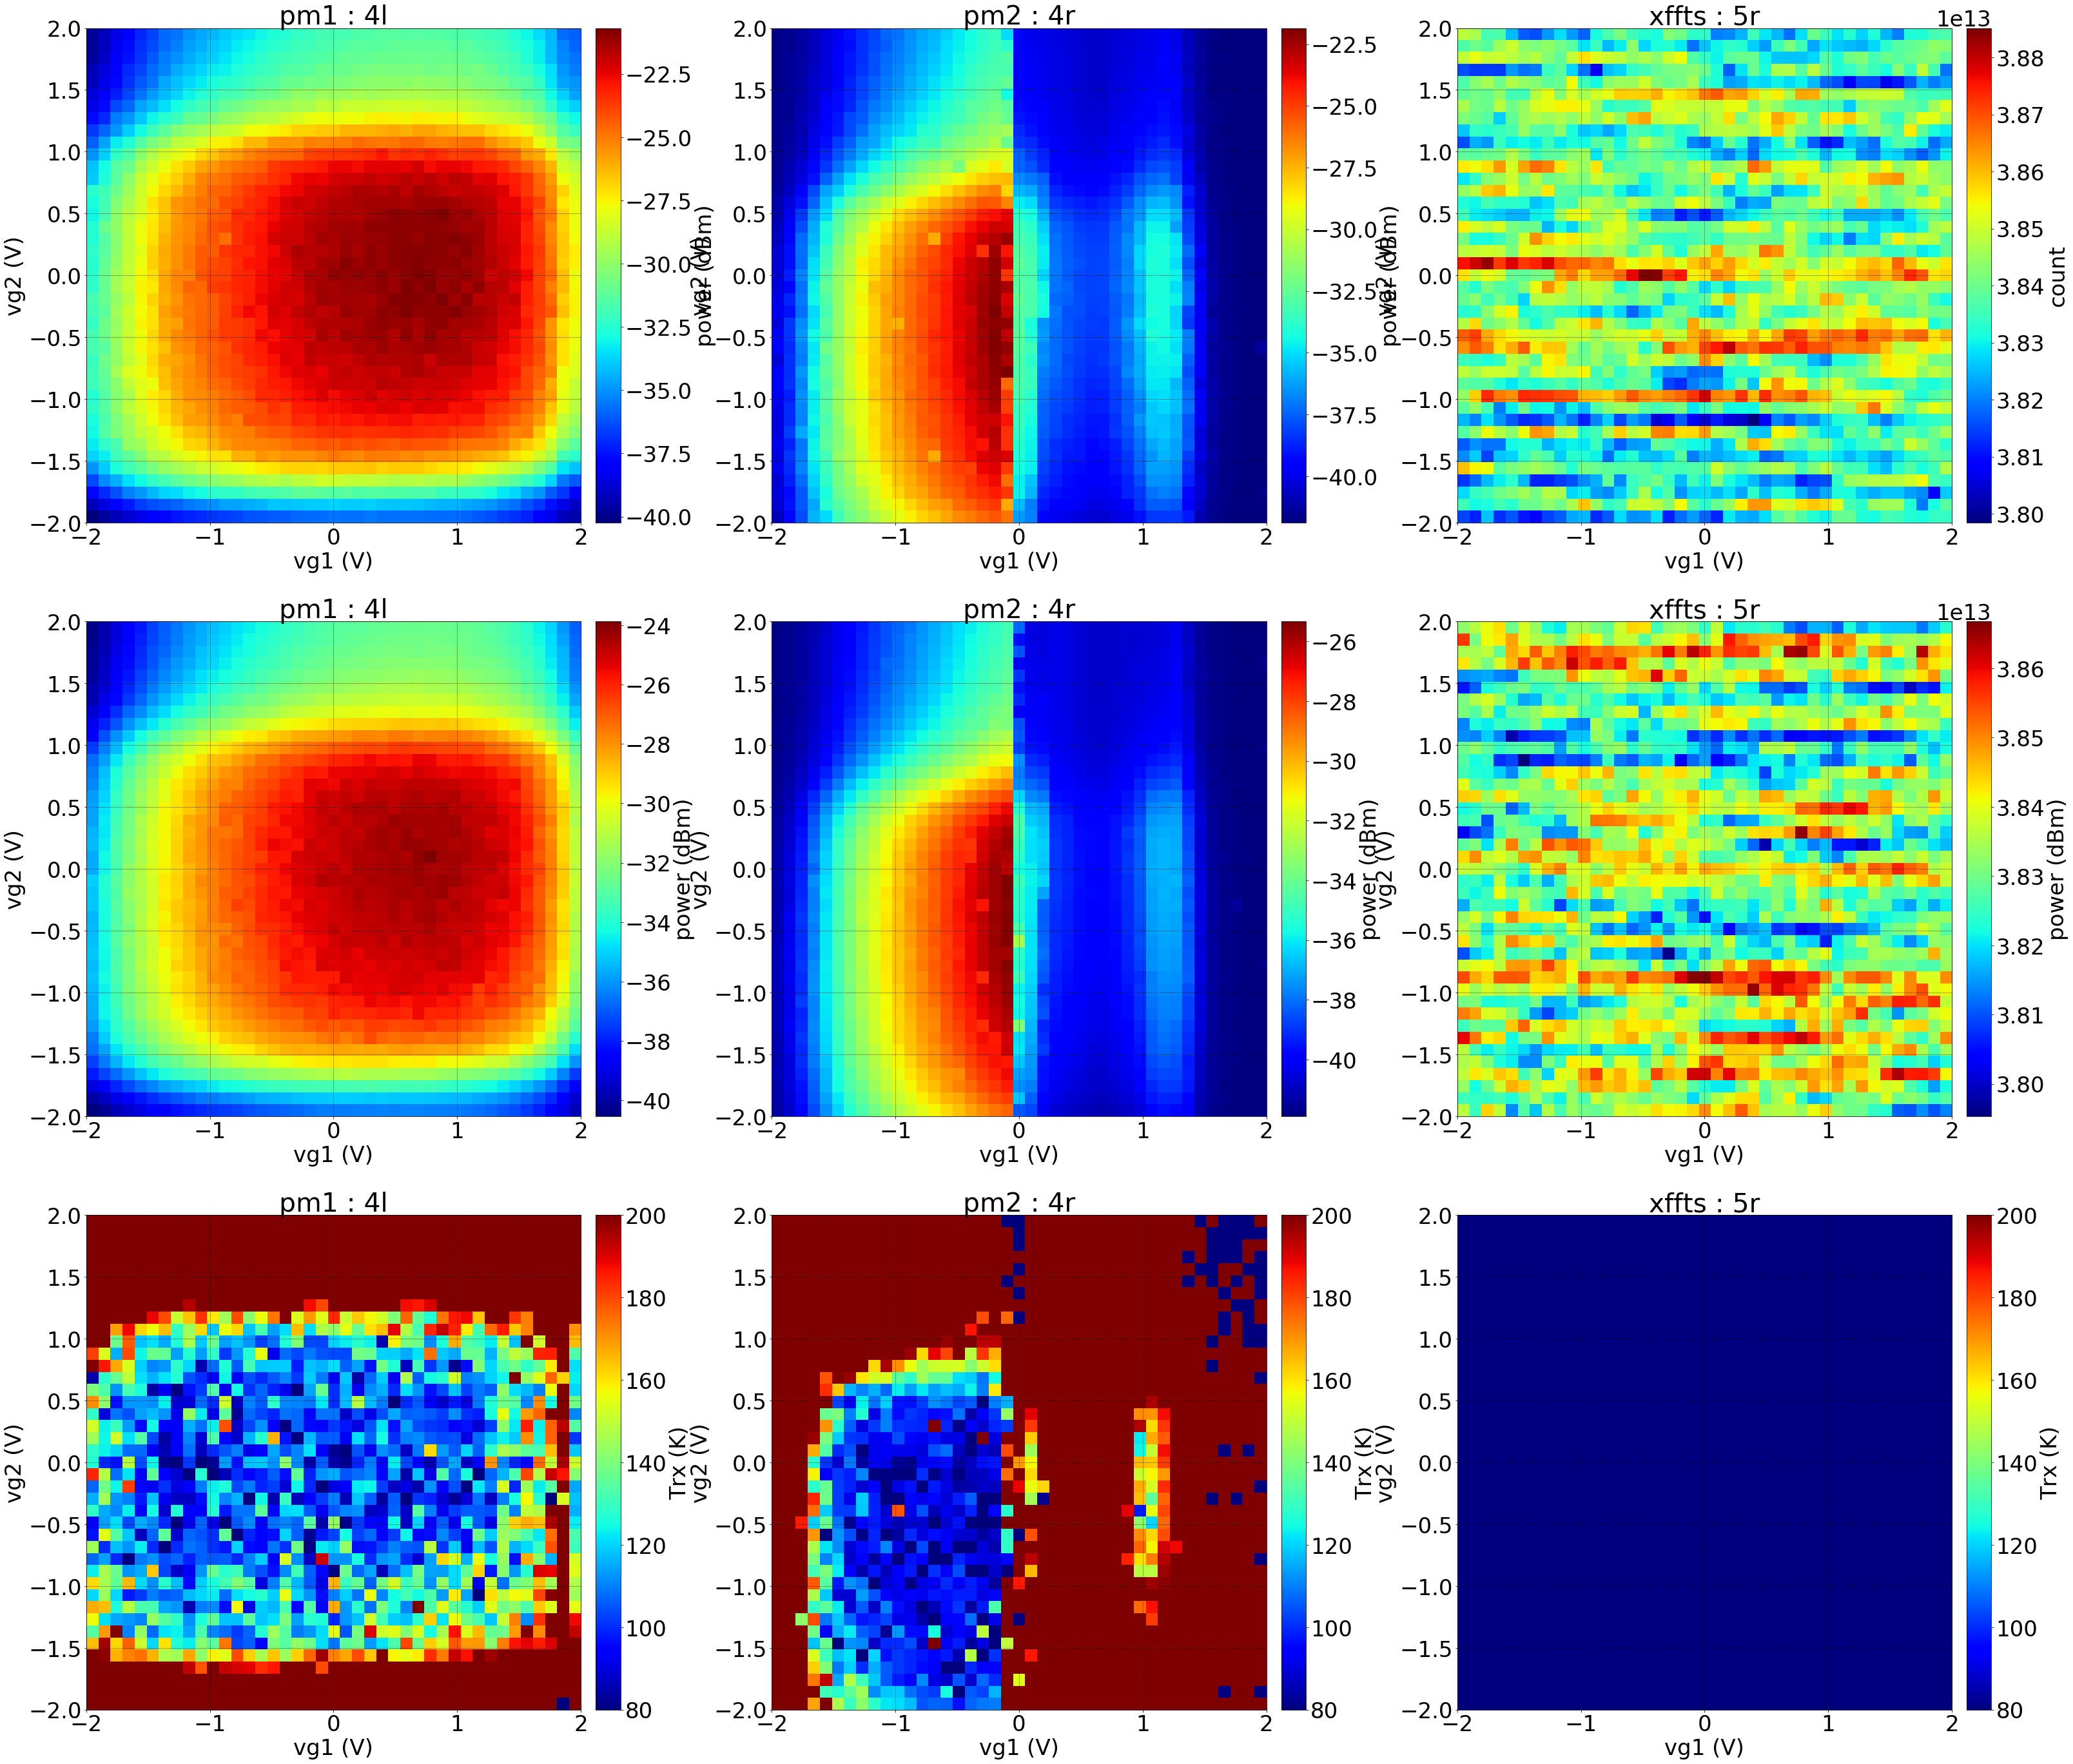

In [36]:
# hot / cold / Trx map.

matplotlib.rcParams['savefig.dpi'] = 100
matplotlib.rcParams['font.size'] = 34
matplotlib.rcParams['image.interpolation']= 'none'
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'jet'
matplotlib.rcParams['grid.linestyle'] = ':'
matplotlib.rcParams['grid.color'] = 'k'

ncol = 3
nrow = 3
nax = ncol * nrow
figsize = (ncol * 18, nrow * 16)
fig = matplotlib.pyplot.figure(figsize=figsize)

extent = [-2.0, 2.0, -2.0, 2.0]

for _idx, _hot_mean, _beam, _backend in zip(range(int(nax/3)), hot_mean, beam, backend):
    ax = fig.add_subplot(nrow, ncol, _idx+1)   
    ax.set_xlabel('vg1 (V)')
    ax.set_ylabel('vg2 (V)')    
    ax.grid()    
    im = ax.imshow(_hot_mean, interpolation='none', extent=extent)
    #ax.set_yticklabels(vg2_map)  
    #ax.set_xticklabels(vg1_map) 
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    if _idx in [0, 1]:
        fig.colorbar(im, cax=cax, ).set_label('power (dBm)')
    if _idx in [2]:
        fig.colorbar(im, cax=cax, ).set_label('count')
    ax.set_title('{} : {}'.format(_backend, _beam))    


for _idx, _cold_mean, _beam, _backend in zip(range(3, 6), cold_mean, beam, backend):
    ax = fig.add_subplot(nrow, ncol, _idx+1)
    #ax.set_xticklabels(vg1_map)
    #ax.set_yticklabels(vg2_map)    
    ax.set_xlabel('vg1 (V)')
    ax.set_ylabel('vg2 (V)')    
    ax.grid()    
    im = ax.imshow(_cold_mean, interpolation='none', extent=extent)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    fig.colorbar(im, cax=cax, ).set_label('power (dBm)')
    ax.set_title('{} : {}'.format(_backend, _beam))        
    
for _idx, _Trx, _beam, _backend in zip(range(6, 9), Trx, beam, backend):
    ax = fig.add_subplot(nrow, ncol, _idx+1)
    #ax.set_xticklabels(vg1_map)
    #ax.set_yticklabels(vg2_map)    
    ax.set_xlabel('vg1 (V)')
    ax.set_ylabel('vg2 (V)')    
    ax.grid()    
    im = ax.imshow(_Trx, interpolation='none', vmax=200, vmin=80, extent=extent)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    fig.colorbar(im, cax=cax, ).set_label('Trx (K)')
    ax.set_title('{} : {}'.format(_backend, _beam))    
    
matplotlib.pyplot.savefig('/home/amigos/Desktop/hemt_tuning.png')
matplotlib.pyplot.show()

In [32]:
hot_mean

[[[-40.24084142736486,
   -39.63134765625,
   -39.25953584558823,
   -38.84765625,
   -38.414481026785715,
   -38.021240234375,
   -37.7001953125,
   -37.36253004807692,
   -37.14634486607143,
   -37.018229166666664,
   -36.7490234375,
   -36.62548828125,
   -36.469482421875,
   -36.188151041666664,
   -36.17138671875,
   -36.00484913793103,
   -35.98741319444444,
   -35.765422952586206,
   -35.71079799107143,
   -35.68885216346154,
   -35.548095703125,
   -35.654296875,
   -35.60901988636363,
   -35.462109375,
   -35.62387319711539,
   -35.616629464285715,
   -35.585307459677416,
   -35.6240234375,
   -35.680338541666664,
   -35.716552734375,
   -35.728125,
   -35.849184782608695,
   -36.044921875,
   -36.312971443965516,
   -36.62109375,
   -36.84273097826087,
   -37.11181640625,
   -37.838429418103445,
   -38.286830357142854,
   -39.200492527173914,
   -39.51708984375],
  [-39.1884765625,
   -38.521484375,
   -37.974609375,
   -37.318115234375,
   -36.64784307065217,
   -36.28255208